# **INTRODUCTION**

This notebook is a supplement for my notebook at below URL that was for Exploratory Data Analysis of Favorita Supermarket chain Dataset.

https://www.kaggle.com/code/adnanshikh/listen-to-secrets-in-your-data

In this notebook, I will try to demonstrate the machine learning models creation that can predict target sales for Favorita Supermarket chain with mean squared log error equal to: **0.564**

I hope this notebook to be a referance for ML engineers, and it will be my plessure to have feedback from you.

So, Let's get strating..

# **IMPORTING PACKAGES**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error, mean_squared_error
from sklearn.preprocessing import LabelEncoder
from statsmodels.tsa.deterministic import DeterministicProcess, CalendarFourier

from warnings import simplefilter
simplefilter('ignore')

## Set Plot Parameters
sns.set(color_codes=True)        
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 5))
plt.rc("axes", labelweight="bold", labelsize="large", titleweight="bold", titlesize=14, titlepad=10)
plot_params = dict(color="0.75", style=".-", markeredgecolor="0.25", markerfacecolor="0.25", legend=False)

# **IMPORTING DATASETS**

In [2]:
path='../input/store-sales-time-series-forecasting/'  ## Path of datasets

## Train & Test Datasets
train=pd.read_csv(path+'train.csv',parse_dates=['date'],
                  dtype={'store_nbr':'int8', 'family':'category', 'sales':'float32',
                        'onpromotion':'int16','id':'int32'} ,infer_datetime_format= True)


test=pd.read_csv(path+'test.csv',parse_dates=['date'],
                 dtype={'store_nbr':'int8', 'family':'category','onpromotion':'int16','id':'int32'},
                 infer_datetime_format= True)

## Supplementary Datasets
oil=pd.read_csv(path+'oil.csv',parse_dates=['date'], infer_datetime_format= True)
holidays_events=pd.read_csv(path+'holidays_events.csv',parse_dates=['date'], infer_datetime_format= True)

## Train Dataset conversion from large to wide 
## Because of prediction is for only 16 days, I'll use data from 2017 only
store_sales = train.drop('id',axis=1).set_index(['store_nbr','family','date'])

family_sales = store_sales.drop('onpromotion', axis=1).unstack(['store_nbr','family']).loc['2017'] # stack：将数据的列“旋转”为行
family_sales.index = family_sales.index.to_period('D')

# **CREATE SEASONAL FEATURES**

We saw from EDA noteboke that sales time series exhibits quadratic trend and both of weekly & annual seasonality.

Here I selected only 2017 year for prediction of 16 days, so I will use DeterministicProcess and CalendarFourier to create:

- Indicators for weekly seasons.

- Linear order of trend.

- Fourier features of order 4 for monthly seasons.

In [3]:
y = family_sales.loc(axis=1)['sales']
fourier = CalendarFourier(freq='M', order=4) ## Fourier features of order 4 for monthly seasons, freq是周期，order是阶数
dp =  DeterministicProcess(index = y.index, seasonal = True,  
                          order = 1, additional_terms = [fourier], drop = True)
X_train_1 = dp.in_sample()

# **HOLIDAY EFFECT**

As found from my EDA notebook, there is a high correlation between the target varibale "sales" and holidays & weekends.

For remeber weekends and holidays are positively correlated with the sales.

I will bring these variables to the model building, so high accurate sales prediction can be acheived. 

In [4]:
## Drop Transferred & Workday Holidays
holidays_events= holidays_events.loc[(holidays_events.transferred==False) & (holidays_events.type != 'Work Day') & (holidays_events.locale != 'Local')]

## Drop Duplicated Holiday Days:
holidays_events.drop_duplicates('date', inplace=True)
holidays_events = holidays_events[['date','type']] ## Keep date & holiday type for merging

## Merging and Mapping:
X_train_1.index = X_train_1.index.to_timestamp()
X_train_1=X_train_1.reset_index().merge(holidays_events,on='date',how='left')
X_train_1.rename({'type':'is_holiday'}, axis=1, inplace=True)
X_train_1['is_holiday']=X_train_1.is_holiday.map({'Holiday':1, 'Transfer':1, 'Additional':1,
                                                      'Bridge':1, 'Event':1})
X_train_1['is_holiday']=X_train_1['is_holiday'].fillna(0).astype('int8')

## Adding weekends to holiday as well
X_train_1['day_of_week'] = X_train_1.date.dt.day_of_week.astype('int8')
X_train_1.loc[(X_train_1['day_of_week']==5) | (X_train_1['day_of_week']==6), 'is_holiday'] = 1
X_train_1.drop('day_of_week',axis=1, inplace=True)

## Removing the first day of a year from holidays.
X_train_1['start_of_year']= (X_train_1.date.dt.dayofyear ==1)
## 在所有的年中开始的一天，并且是节假日的置为0
X_train_1.loc[X_train_1['start_of_year']==True, 'is_holiday']=0
X_train_1['start_of_year'] = X_train_1['start_of_year'].astype('int8')

X_train_1 = X_train_1.set_index('date')
X_train_1.index = X_train_1.index.to_period('D')

# **HYPRID MODELS**

Linear regression excels at extrapolating trends, but can't learn interactions. CATBoost excels at learning interactions, but can't extrapolate trends. In the next codes, I'll create "hybrid" forecasters that combine complementary learning algorithms and let the strengths of one make up for the weakness of the other.

# **COMPONENTS AND RESIDUALS**

So that we can design effective hybrids, we need a better understanding of how time series are constructed. Many time series can be closely described by an additive model of just three components (Seasons, trend, and cycles) plus some essentially unpredictable, entirely random error.

series = trend + seasons + cycles + error

The residuals of a model are the difference between the target the model was trained on and the predictions the model makes.

Add together all the components we learned and we get the complete model. This is essentially what linear regression would do if you trained it on a complete set of features modeling trend, seasons, and cycles.

# **HYBRID FORCASTING WITH RESIDUALS**

It's possible to use one algorithm for some of the components and another algorithm for the rest. This way we can always choose the best algorithm for each component. To do this, we use one algorithm to fit the original series and then the second algorithm to fit the residual series.

In detail, the process is this:

1. Train and predict with first model

model_1.fit(X_train_1, y_train)

y_pred_1 = model_1.predict(X_train)

2. Train and predict with second model on residuals

model_2.fit(X_train_2, y_train - y_pred_1)

y_pred_2 = model_2.predict(X_train_2)

3. Add to get overall predictions

y_pred = y_pred_1 + y_pred_2

# **FIT/PREDICT DEFINITIONS FOR HYBRID MODELS**

In [5]:
def fit(model_1, model_2, X_train_1, X_train_2, y):

    """
    Defination for hyprid models fitting.
    Inputs: 
    -   modeal_1: the 1st model.
    -   model_2: the 2nd model.
    -   X_train_1: training data for model_1.
    -   X_train_2: trainng data fro model_2.
    -   y: target of training data of model_1.
    Output:
    -   Hyprid models fitting.
    """
    
    model_1.fit(X_train_1,y)

    # Make predictions with model_1
    y_fit = pd.DataFrame(model_1.predict(X_train_1), index=X_train_1.index, columns=y.columns)

    y_resid = y - y_fit # compute residuals
    y_resid = y_resid.unstack().reset_index(['store_nbr','family','date']) # wide to long
    y_resid['date'] = y_resid['date'].dt.to_timestamp()
    y_resid = y_resid.set_index(['store_nbr','family','date'])
    y_resid.rename({0:'residuals'},axis=1,inplace=True)
    
    # re-order the index of y_resid as the index of X_train_2
    new_index=X_train_2.copy()
    new_index['family']=le.inverse_transform(new_index['family']) # inverse transform label encoder for family
    new_index=new_index.reset_index().set_index(['store_nbr','family','date'])
    y_resid = y_resid.reindex(new_index.index)
    
    y_resid.reset_index(['store_nbr','family'], drop=True, inplace=True) # drop unneccessary varibales
    
    model_2.fit(X_train_2, y_resid)

def predict(model_1, model_2, X_train_1, X_train_2):
    
    """
    Defination for hyprid models prediction.
    Inputs: 
    -   modeal_1: the 1st model (fiited).
    -   model_2: the 2nd model (fiited).
    -   X_train_1: training data for model_1.
    -   X_train_2: trainng data fro model_2.
    Output:
    -   y_pred: final prediction of hyprid models.
    """
    
    global y 
    y_pred = pd.DataFrame(model_1.predict(X_train_1), index=X_train_1.index, columns=y.columns) # prediction of 1st model

    y_pred = y_pred.unstack().reset_index(['store_nbr','family','date']) # wide to long
    y_pred['date'] = y_pred['date'].dt.to_timestamp()
    y_pred = y_pred.set_index(['store_nbr','family','date'])
    y_pred.rename({0:'sales'},axis=1,inplace=True)
    
    # re-order the index of y_pred as the index of X_train_2
    new_index=X_train_2.copy()
    new_index['family']=le.inverse_transform(new_index['family']) # inverse transform label encoder for family
    new_index=new_index.reset_index().set_index(['store_nbr','family','date'])
    y_pred = y_pred.reindex(new_index.index)
    
    values = y_pred['sales'].values
    sales = model_2.predict(X_train_2) + values
    y_pred['sales'] = sales.clip(0.0)  ## clipping values < 0 to 0.0
    
    return y_pred 

# **HYPRID MODELS TRAINING/PREDICTION**

In [6]:
model_1 = LinearRegression() 

model_2 = CatBoostRegressor(silent= True) ## by default hyperparameter

# X_train_2: Features for CatBoost
X_train_2 = train.drop(['id','sales'],axis=1).set_index('date').loc['2017']

# Label encoding for 'family'
le = LabelEncoder()
X_train_2['family'] = le.fit_transform(X_train_2['family'])

X_train_2['start_of_year']= (X_train_2.index.dayofyear ==1).astype('int8')


fit(model_1, model_2, X_train_1, X_train_2, y)

y_pred= predict(model_1, model_2, X_train_1, X_train_2)

# **HYPER MODELS EVALUATION**

We can look to the diagram of the true average sales vs. the predicted ones, as determine if our hyper models doing well or not.

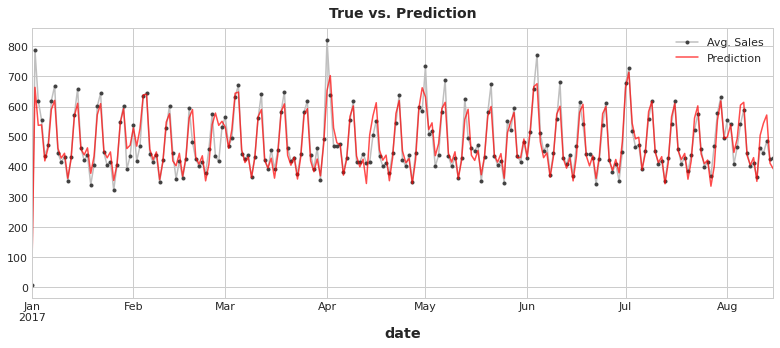

In [7]:
ax=y.mean(axis=1).plot(**plot_params, label='Avg. Sales', title='True vs. Prediction')
ax=y_pred.groupby('date')['sales'].mean().plot(color='red', alpha=0.7, label='Prediction', legend=True)
ax=plt.legend()
plt.show()

# **TEST DATA PREPARATION**

In [8]:
X_test_1 = dp.out_of_sample(steps = 16) # 16 because we are predicting next 16 days
X_test_1.index = X_test_1.index.rename('date').to_timestamp()

## Merging and Mapping:
X_test_1=X_test_1.reset_index().merge(holidays_events,on='date',how='left').set_index('date')
X_test_1.rename({'type':'is_holiday'}, axis=1, inplace=True)
X_test_1['is_holiday']=X_test_1.is_holiday.map({'Holiday':1, 'Transfer':1, 'Additional':1,
                                                      'Bridge':1, 'Event':1})
X_test_1['is_holiday']=X_test_1['is_holiday'].fillna(0).astype('int8')

## Adding weekends to holiday as well
X_test_1['day_of_week'] = X_test_1.index.day_of_week.astype('int8')
X_test_1.loc[(X_test_1['day_of_week']==5) | (X_test_1['day_of_week']==6), 'is_holiday'] = 1
X_test_1.drop('day_of_week',axis=1, inplace=True)

## Removing the first day of a year from holidays as mentioned before Favorita is closed these days.
X_test_1['start_of_year']= (X_test_1.index.dayofyear ==1)
X_test_1.loc[X_test_1['start_of_year']==True, 'is_holiday']=0
X_test_1['start_of_year'] = X_test_1['start_of_year'].astype('int8')
X_test_1.index = X_test_1.index.to_period('D')

X_test_2=test.set_index('date')
X_test_2 = X_test_2.drop('id', axis = 1)
X_test_2['start_of_year']= (X_test_2.index.dayofyear ==1).astype('int8')
X_test_2['family'] = le.transform(test['family'])

In [9]:
target = predict(model_1, model_2, X_test_1, X_test_2)

# **SUBMISSION**

In [10]:
submission=pd.read_csv(path+'sample_submission.csv')
submission['sales']=target.reset_index()['sales']
submission.to_csv('/kaggle/working/submission.csv', index=False)

In [11]:
submission.head()

,id,sales
0,3000888,5.386396
1,3000889,1.102873
2,3000890,5.101053
3,3000891,2307.544174
4,3000892,0.729912
